In [24]:
# This program draws;
# the relation between
#    (X) Stock/Flow ratio, and
#    (Z) the price of Bitcoin

In [25]:
# references
# [1] https://medium.com/@100trillionUSD
# [2] https://money.usnews.com/investing/articles/the-history-of-bitcoin
# [3] https://money.usnews.com/investing/investing-101/articles/bitcoin-halving-101-what-is-it-and-why-does-it-matter
# [4] https://www.blockchain.com/explorer/charts/market-price

# History
# 2009-01-03: Initial release with 50 BTC/block reward
# 2012-11-28: 1st halving (1,425 days later)
# 2016-07-09: 2nd halving (1,319 days later)
# 2020-05-11: 3rd halving (1,402 days later)

# Let halving happens every 1,382 days, the average of the 3 intervals above, after the 3rd halving
# Let the reward rounds down to the satoshi (10**-8 BTC)

In [1]:
import math
import json

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

Stock/Flow

In [2]:
# pd.options.display.precision = 8
pd.options.display.float_format = '{:.8f}'.format
unit_satoshi = 10**-8
max_date = '2099-10-27'

halving_dates = pd.DatetimeIndex(['2009-01-03','2012-11-28','2016-07-09']).union(pd.date_range('2020-05-11',max_date,freq='1382D'))

_df_quantity = pd.DataFrame({
    'reward':[math.floor((50*0.5**i)/unit_satoshi)*unit_satoshi for i in range(len(halving_dates))],
    'duration':[1425,1319,1402]+[1382]*(len(halving_dates)-3)
},
    index=halving_dates
)

_df_quantity['daily_issuance'] = 210_000 / _df_quantity['duration'] * _df_quantity['reward']

df_quantity = _df_quantity.reindex(index=pd.date_range('2009-01-03',max_date,freq='D'),method='ffill')

df_quantity['Stock'] = df_quantity['daily_issuance'].cumsum()
df_quantity['Flow'] = df_quantity['daily_issuance'].rolling(365).sum().shift(-365)

df_quantity['Stock_to_Flow'] = df_quantity['Stock']/df_quantity['Flow']

Price

In [3]:
json_price = json.load(open('../input/20230708_market-price.json','r'))
df_price_json = pd.DataFrame(json_price['market-price'])

df_price_json['x'] = pd.to_datetime(df_price_json['x'],unit='ms')
df_price_json.set_index('x',inplace=True)

In [4]:
df_price_yf = yf.download(['BTC-USD'],interval='1d',period='max')

[*********************100%***********************]  1 of 1 completed


In [5]:
df_price = pd.concat([df_price_json,df_price_yf['Close']],axis=1)
df_price['Price'] = df_price['Close'].fillna(df_price['y'])

df_price = df_price.reindex(index=pd.date_range(min(df_price.index),max(df_price.index),freq='D'),method='ffill')

Merge

In [6]:
df = pd.concat([df_quantity,df_price],axis=1)

In [10]:
df[['Stock','Stock_to_Flow','Price']].to_csv('../input/20230710_bitcoin_s2f.csv')

Draw

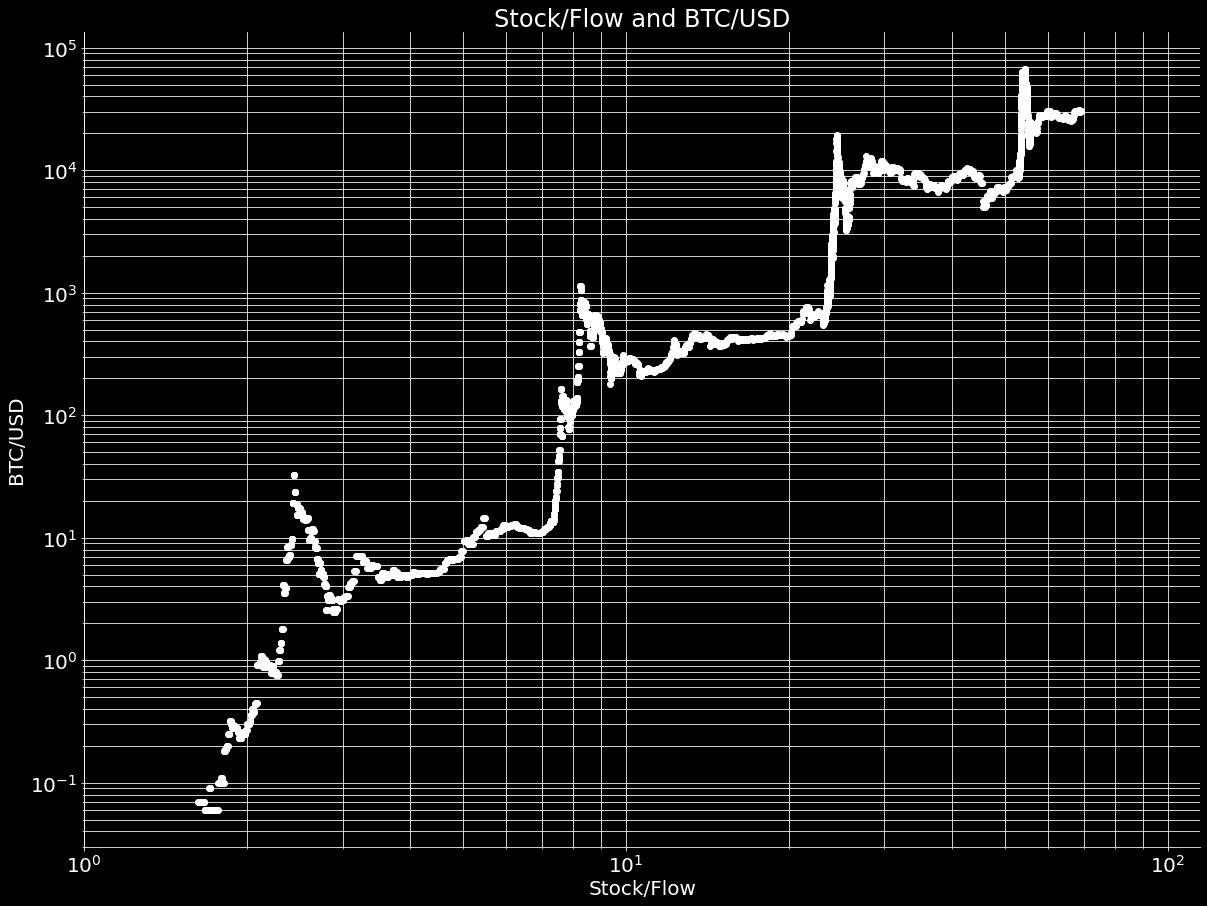

In [32]:
plt.figure(figsize=(20,15))
plt.rcParams['font.size'] = 20
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.style.use('dark_background')

plt.scatter(df['Stock_to_Flow'],df['Price'],color='white')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1,None)
# plt.ylim(0,None)
plt.grid(which='both',axis='both')

plt.title(f"Stock/Flow and BTC/USD")
plt.xlabel("Stock/Flow")
plt.ylabel("BTC/USD")

plt.show()

In [33]:
df_log = np.log10(df[['Stock_to_Flow','Price']].dropna().query('Price>0'))

corr = np.correlate(df_log['Stock_to_Flow'],df_log['Price'])
print(f'corr = {corr}')

slope,intercept = np.polyfit(x=df_log['Stock_to_Flow'],y=df_log['Price'],deg=1)
print(f'log10(Y) = {intercept} + {slope} * log10(X)')
print(f'Y = (10 ** {intercept}) * (X ** {slope})')

corr = [19595.83399399]
log10(Y) = -0.8276547402760593 + 3.071332991657172 * log10(X)
Y = (10 ** -0.8276547402760593) * (X ** 3.071332991657172)


In [34]:
df_plot = df.query('Price.isna() or Price>0').head(365*17)

fig,ax1 = plt.subplots(figsize=(20,15))
ax2 = ax1.twinx()
plt.rcParams['font.size'] = 20
plt.style.use('dark_background')
plt.gca().spines['top'].set_visible(False)

ax2.plot((10**intercept)*(df_plot['Stock_to_Flow']**slope),color='white',linewidth=2)
ax1.plot(df_plot['Price'],color='yellow',linewidth=4)

ax1.set_yscale('log')
ax2.set_yscale('log')
n = 6
ax1.set_ylim(0.1,10**n)
ax2.set_ylim(0.1,10**n)

xticks=[d for d in df_plot.index if d.month==1 and d.day==1]
ax1.set_xticks(ticks=xticks, labels=[d.year for d in xticks])
for i in xticks:
    ax1.axvline(x=i,color="grey",linewidth=2)
for i in [d for d in df_plot.index if d.month%3==1 and d.day==1]:
    ax1.axvline(x=i,color="grey",linewidth=0.5)

yticks=[10**i for i in range(-1,n+1)]
ax1.set_yticks(ticks=yticks, labels=[f'${10**i:,}' for i in range(-1,n+1)])
ax2.set_yticks(ticks=yticks, labels=[f'{10**i:,}' for i in range(-1,n+1)])
for i in yticks:
    ax1.axhline(y=i,color="grey",linewidth=2)
    for j in range(10):
        ax1.axhline(y=i*j,color="grey",linewidth=0.5)

ax1.set_title(f'Stock/Flow and Price of Bitcoin')
ax1.set_xlabel("Year")
ax1.set_ylabel("BTC/USD")
ax2.set_ylabel(f"{10**intercept:.2f} * ( Stock/Flow ** {slope:.2f} )")

fig.savefig("../output/20230708_Stock_to_Flow_Bitcoin.png")
plt.close()